In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('/share/u/wendler/code/my-sdxl-unbox')

In [2]:
n = 10
path_to_checkpoints = '../hparam_study/'#'../checkpoints/'#'../hparam_study/'
k = 160
exp = 4
n_timesteps = 1
use_vanilla = False
dtype="fp16"

In [4]:
outfile = f"timestep_generalization_n{n}_t{n_timesteps}_{'vanilla' if use_vanilla else 'turbo'}_k{k}_exp{exp}_cfgidx{cfg_idx}.csv"

In [5]:
n_feats = exp * 1280

In [ ]:
import os
import gradio as gr
import torch
from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from app import create_demo
assert torch.cuda.is_available(), "Your machine has no access to GPU. If you are using Colab, consider changing environment"
# The SAEs were trained to work with torch.float32, but they can also work with torch.float16
# Change this value to torch.float32 if you have access to a GPU with >30GB of memory
if dtype == "fp32":
    dtype = torch.float32
else:
    dtype = torch.float16

sdxl_turbo = "stabilityai/sdxl-turbo" 
sdxl = "stabilityai/stable-diffusion-xl-base-1.0"
if not use_vanilla:
    model_name = sdxl_turbo 
else:
    model_name = sdxl

pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [25]:
code_to_block = {
    "down.2.1": "unet.down_blocks.2.attentions.1",
    "mid.0": "unet.mid_block.attentions.0",
    "up.0.1": "unet.up_blocks.0.attentions.1",
    "up.0.0": "unet.up_blocks.0.attentions.0"
}

saes_dict = {}
means_dict = {}

for code, block in code_to_block.items():
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{n_feats}_auxk256_bs4096_lr0.0001", "final"),
    )
    saes_dict[code] = sae.to('cuda', dtype=dtype)

In [31]:
import numpy as np
from matplotlib import pyplot as plt
import json
if n > 5:
    with open('/tmp/wendler/first_50K_prompts.json', 'r') as f:
        prompts = json.load(f)
    prompts = [p["caption"] for p in prompts[n:2*n]]
else:
    prompts = [
        "A photo of a cat",
        "A photo of a dog",
        "A photo of a bird",
        "A photo of a fish",
        "A photo of a horse",
    ]

In [ ]:
prompts

['A bed with white and red bedspread in a bedroom.',
 'The characters are riding horses in the snow.',
 'Two framed pictures hanging on the wall next to each other.',
 'An airplane flying in the sky with its landing gear down.',
 'A man is digging in the ground to install a fence.',
 'An orange and white google home speaker next to a gray google assistant.',
 'A man in camouflage holding his camera and talking on the phone.',
 'Two women in gold dresses posing for the camera.',
 'A blue backpack with Avengers characters on it.',
 'The richmond grey bedside table with a drawer.']

In [33]:
# find out the models inside of pipe
if dtype == torch.float32:
    pipe.text_encoder.to(dtype=torch.float32)
    pipe.text_encoder_2.to(dtype=torch.float32)

In [11]:
from collections import defaultdict


In [ ]:
sys.path.append('/share/u/wendler/code/my-sdxl-unbox/scripts')
from train_sae import explained_variance
from tqdm import tqdm
from einops import einsum, rearrange
verbose = False
results = defaultdict(list)
for pidx, prompt in enumerate(tqdm(prompts)):
    output, cache = pipe.run_with_cache(
        prompt,
        positions_to_cache=list(code_to_block.values()),
        save_input=True,
        save_output=True,
        num_inference_steps=n_timesteps,
        guidance_scale=0.0 if not use_vanilla else 7.5,
        generator=torch.Generator(device="cpu").manual_seed(42)
    )
    timesteps = pipe.scheduler.timesteps
    if verbose:
        plt.imshow(output.images[0])
        plt.show()
    for short, long in code_to_block.items():
        for cfg_idx in range(cache['output'][long].shape[0]):
            #print(cache['output'][long].shape)
            diff = cache['output'][long][cfg_idx] - cache['input'][long][cfg_idx]
            # timesteps x features x height x width
            #gprint(short, sae.path)
            sae = saes_dict[short]
            sae.eval()
            diff_perm = diff.permute(0, 2, 3, 1) # 
            # timesteps x height x width x features
            diff_flat = diff_perm.reshape(-1, diff.shape[1])
            # (timesteps * height * width) x features
            recon, info = sae(diff_flat)
            # (timesteps * height * width) x features
            l2_1 = ((diff_flat - recon)**2).sum(dim=-1).mean()
            features = sae.encode(diff_perm)
            # timesteps x height x width x features
            recon_perm = features @ sae.decoder.weight.T + sae.pre_bias
            l2_2 = ((diff_perm - recon_perm)**2).sum(dim=-1).mean()
            # they should be similar
            assert abs(l2_1 - l2_2) < 1e-2, f"l2_1 != l2_2: {l2_1} != {l2_2}"
            fnormalized = features / features.norm(dim=-1, keepdim=True)
            dnormalized = diff_perm / diff_perm.norm(dim=-1, keepdim=True)
            fnormalized = features / features.norm(dim=-1, keepdim=True)
            dnormalized = diff_perm / diff_perm.norm(dim=-1, keepdim=True)
            fbinarized = (features > 0).float()
            fdots = einsum(fnormalized[:-1], fnormalized[1:], "t h w f, t h w f -> t h w").mean(dim=1).mean(dim=1)
            dots = einsum(dnormalized[:-1], dnormalized[1:], "t h w f, t h w f -> t h w").mean(dim=1).mean(dim=1)
            fdots_binarized = einsum(fbinarized[:-1], fbinarized[1:], "t h w f, t h w f -> t h w") # == intersection 
            # union next
            fdots_union = (fbinarized[:-1] + fbinarized[1:]).clamp(0, 1).sum(dim=-1)
            iou = fdots_binarized / fdots_union
            iou_mean = iou.mean(dim=1).mean(dim=1)
            # then .mean(dim=1).mean(dim=1)
            
            recon = recon.reshape(len(timesteps), -1, recon.shape[1]) # this guy breaks things
            # timesteps x (height * width) x features
            for idx in range(diff.shape[0]):
                tmp = diff[idx].permute(1,2,0).reshape(-1, diff_flat.shape[1])
                mse2 = ((recon[idx] - tmp)**2).mean()

                l2 = (diff_perm[idx] - recon_perm[idx]).norm(dim=-1)
                rel_l2 = l2 / diff_perm[idx].norm(dim=-1)
                rel_l2 = rel_l2.mean()
                # expects n x features
                explained_var = explained_variance(diff[idx].permute(1,2,0).reshape(-1, diff.shape[1]), recon[idx])
                if cfg_idx == 0:
                    results["block"].append(short)
                    #results["prompt"].append(prompt)
                    results["tidx"].append(idx)
                    results["t"].append(timesteps[idx].item())
                results[f"mse_{cfg_idx}"].append(mse2.item())
                results[f"explained_var_{cfg_idx}"].append(explained_var.item())
                results[f"relative_norm_{cfg_idx}"].append(rel_l2.item())
                if idx == diff.shape[0] - 1:
                    results[f"fdots_{cfg_idx}"].append(0.0)
                    results[f"dots_{cfg_idx}"].append(0.0)
                    results[f"iou_{cfg_idx}"].append(0.0)
                else:
                    results[f"fdots_{cfg_idx}"].append(fdots[idx].item())
                    results[f"dots_{cfg_idx}"].append(dots[idx].item())
                    results[f"iou_{cfg_idx}"].append(iou_mean[idx].item())
from pandas import DataFrame
df = DataFrame(results)
df.to_csv(outfile)
df

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


,block,tidx,t,mse_0,explained_var_0,relative_norm_0,fdots_0,dots_0,iou_0,mse_1,explained_var_1,relative_norm_1,fdots_1,dots_1,iou_1
0,down.2.1,0,1.0,0.941734,0.556588,0.526059,0.0,0.0,0.0,1.007013,0.558613,0.528363,0.0,0.0,0.0
1,mid.0,0,1.0,4.872584,0.575395,0.551086,0.0,0.0,0.0,4.789230,0.575540,0.548595,0.0,0.0,0.0
2,up.0.1,0,1.0,4.290729,0.598621,0.414627,0.0,0.0,0.0,4.363551,0.595579,0.413685,0.0,0.0,0.0
3,up.0.0,0,1.0,1.883613,0.613275,0.512578,0.0,0.0,0.0,1.905933,0.611262,0.516901,0.0,0.0,0.0
4,down.2.1,0,1.0,0.941734,0.556588,0.526059,0.0,0.0,0.0,1.006768,0.554591,0.536031,0.0,0.0,0.0
5,mid.0,0,1.0,4.872584,0.575395,0.551086,0.0,0.0,0.0,4.850833,0.572364,0.548585,0.0,0.0,0.0
6,up.0.1,0,1.0,4.290729,0.598621,0.414627,0.0,0.0,0.0,4.382377,0.601644,0.417276,0.0,0.0,0.0
7,up.0.0,0,1.0,1.883613,0.613275,0.512578,0.0,0.0,0.0,1.910369,0.611291,0.515100,0.0,0.0,0.0
8,down.2.1,0,1.0,0.941734,0.556588,0.526059,0.0,0.0,0.0,1.013217,0.552561,0.533569,0.0,0.0,0.0
9,mid.0,0,1.0,4.872584,0.575395,0.551086,0.0,0.0,0.0,4.840436,0.576075,0.549682,0.0,0.0,0.0


In [36]:
df.groupby(["block", "tidx"]).mean().reset_index()

,block,tidx,t,mse_0,explained_var_0,relative_norm_0,fdots_0,dots_0,iou_0,mse_1,explained_var_1,relative_norm_1,fdots_1,dots_1,iou_1
0,down.2.1,0,1.0,0.941734,0.556588,0.526059,0.0,0.0,0.0,1.015594,0.555342,0.532688,0.0,0.0,0.0
1,mid.0,0,1.0,4.872584,0.575395,0.551086,0.0,0.0,0.0,4.827499,0.574644,0.549132,0.0,0.0,0.0
2,up.0.0,0,1.0,1.883613,0.613275,0.512578,0.0,0.0,0.0,1.905193,0.615274,0.513763,0.0,0.0,0.0
3,up.0.1,0,1.0,4.290729,0.598621,0.414627,0.0,0.0,0.0,4.329430,0.599803,0.414882,0.0,0.0,0.0


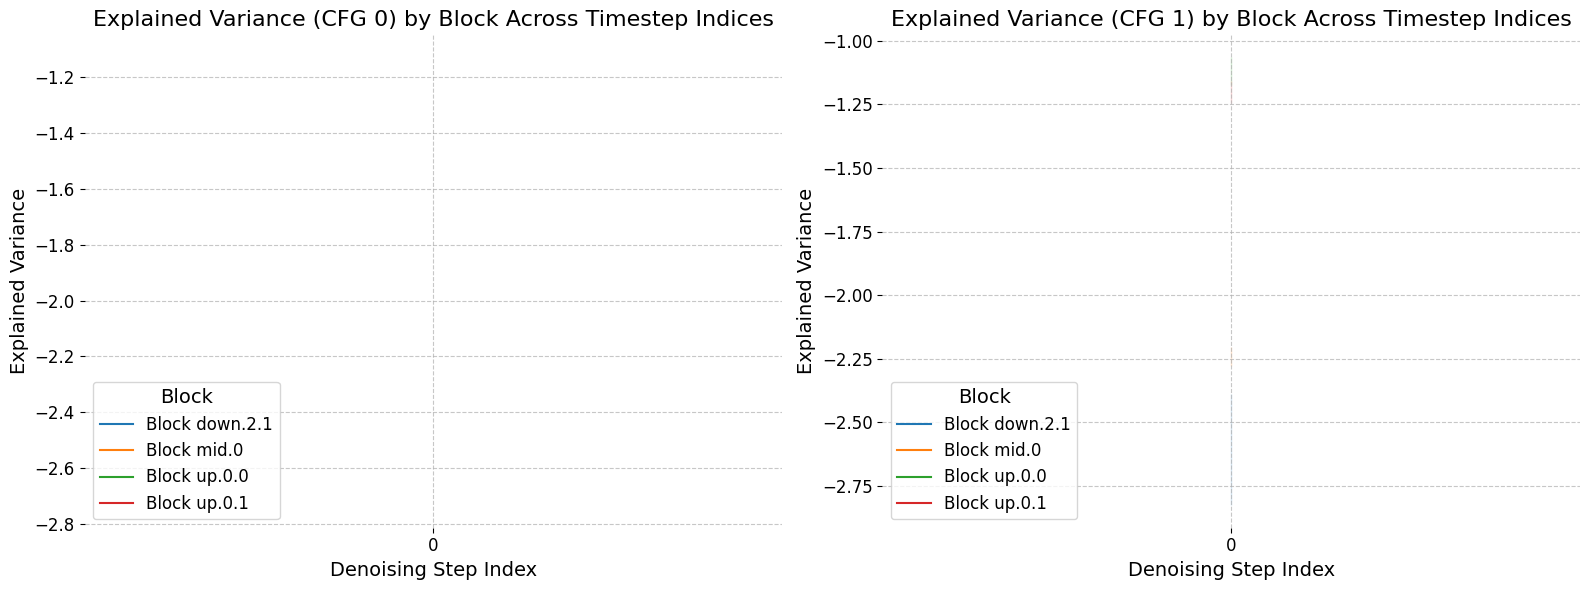

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with subplots for each cfg_idx
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get the number of cfg indices
cfg_indices = [0, 1]  # Assuming we have cfg_idx 0 and 1

for cfg_idx, ax in zip(cfg_indices, axes):
    # Group by block and tidx to get mean and std of explained variance for this cfg_idx
    var_col = f"explained_var_{cfg_idx}"
    summary_df = df.groupby(["block", "tidx"])[var_col].agg(['mean', 'std']).reset_index()
    
    # Remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    blocks = summary_df['block'].unique()
    colors = sns.color_palette(n_colors=len(blocks))
    
    for i, block in enumerate(blocks):
        block_df = summary_df[summary_df['block'] == block]
        ax.plot(block_df['tidx'], block_df['mean'], label=f"Block {block}", color=colors[i])
        # Gaussian confidence interval: mean ± 1.96*std
        lower = block_df['mean'] - 1.96 * block_df['std']/np.sqrt(len(block_df))
        upper = block_df['mean'] + 1.96 * block_df['std']/np.sqrt(len(block_df))
        ax.fill_between(block_df['tidx'], lower, upper, color=colors[i], alpha=0.2)
    
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Increase font size
    ax.set_title(f"Explained Variance (CFG {cfg_idx}) by Block Across Timestep Indices", fontsize=16)
    ax.set_xlabel("Denoising Step Index", fontsize=14)
    ax.set_ylabel("Explained Variance", fontsize=14)
    ax.legend(title="Block", loc='lower left', fontsize=12, title_fontsize=14)
    # they should be just 1 apart
    ax.set_xticks(block_df['tidx'])
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

ValueError: max() iterable argument is empty

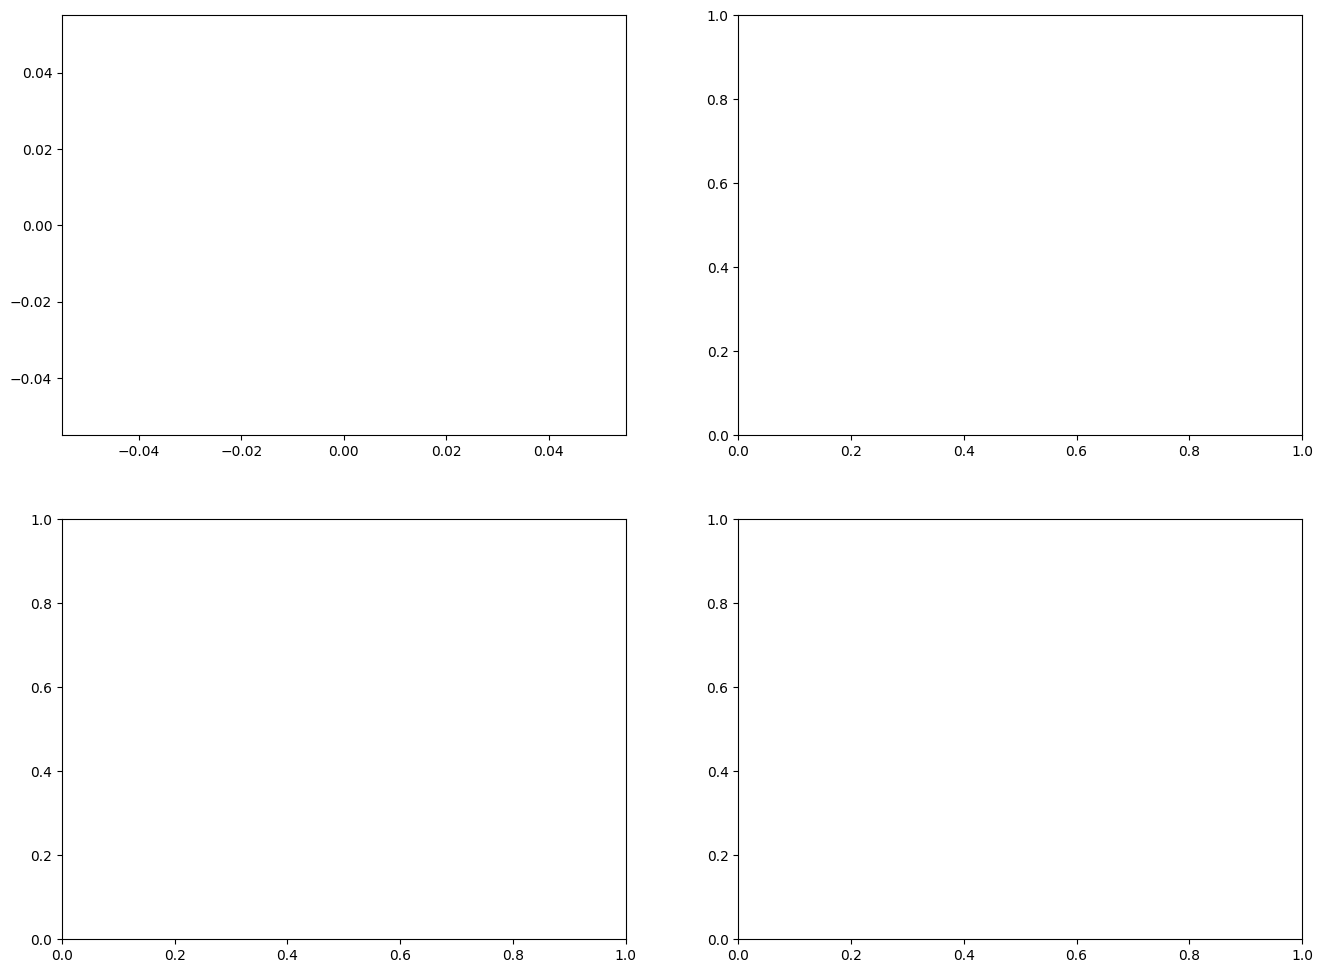

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get unique block names
block_types = sorted(df['block'].unique())

# Get the number of cfg indices
cfg_indices = [0, 1]  # Assuming we have cfg_idx 0 and 1

for cfg_idx in cfg_indices:
    # Create a grid of subplots for this cfg_idx
    n_blocks = len(block_types)
    n_cols = 2
    n_rows = (n_blocks + n_cols - 1) // n_cols  # Ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
    axes = axes.flatten()
    
    # Set common style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    # Colors for different metrics
    colors = {'fdots': 'blue', 'dots': 'red', 'fdots_binarized': 'green'}
    
    for i, block_type in enumerate(block_types):
        if i >= len(axes):
            break
            
        # Filter data for this block type and cfg_idx
        block_data = df[df['block'] == block_type]
        
        # Group by tidx to get mean values
        tidx_groups = block_data.groupby('tidx')
        
        # Get unique tidx values and sort them, excluding the last datapoint which is a placeholder
        tidx_values = sorted(block_data['tidx'].unique())[:-1]  # Remove the last tidx (placeholder)
        
        # Get mean and std values for each tidx and metric, excluding the placeholder
        fdots_col = f"fdots_{cfg_idx}"
        dots_col = f"dots_{cfg_idx}"
        fdots_binarized_col = f"iou_{cfg_idx}"
        
        mean_fdots = [tidx_groups.get_group(tidx)[fdots_col].mean() for tidx in tidx_values]
        std_fdots = [tidx_groups.get_group(tidx)[fdots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_dots = [tidx_groups.get_group(tidx)[dots_col].mean() for tidx in tidx_values]
        std_dots = [tidx_groups.get_group(tidx)[dots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].mean() for tidx in tidx_values]
        std_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        # Plot all three metrics with confidence intervals
        axes[i].plot(tidx_values, mean_fdots, 'o-', label='SAE similarity', linewidth=2, color=colors['fdots'])
        # Add Gaussian confidence interval: mean ± 1.96*std_error
        axes[i].fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                             [m + 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                             color=colors['fdots'], alpha=0.2)
        
        axes[i].plot(tidx_values, mean_dots, 's-', label='activation similarity', linewidth=2, color=colors['dots'])
        axes[i].fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_dots, std_dots)], 
                             [m + 1.96*s for m, s in zip(mean_dots, std_dots)], 
                             color=colors['dots'], alpha=0.2)
        
        # Add a second y-axis for fdots_binarized if the scale is very different
        if max(mean_fdots_binarized) > 5 * max(mean_fdots):
            ax2 = axes[i].twinx()
            ax2.plot(tidx_values, mean_fdots_binarized, '^-', label='SAE IoU', linewidth=2, color=colors['fdots_binarized'])
            ax2.fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                             [m + 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                             color=colors['fdots_binarized'], alpha=0.2)
            ax2.set_ylabel('FDots Binarized Value', fontsize=14, color=colors['fdots_binarized'])
            ax2.tick_params(axis='y', labelcolor=colors['fdots_binarized'])
            # Don't plot fdots_binarized on the first axis if we're using a second axis
        else:
            # Only plot on the first axis if we're not using a second axis
            axes[i].plot(tidx_values, mean_fdots_binarized, '^-', label='SAE IoU', linewidth=2, color=colors['fdots_binarized'])
            axes[i].fill_between(tidx_values, 
                                 [m - 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                                 [m + 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                                 color=colors['fdots_binarized'], alpha=0.2)
            
        # Add labels and title
        axes[i].set_title(f"Block: {block_type} (CFG {cfg_idx})", fontsize=16)
        axes[i].set_xlabel("Denoising Step Index", fontsize=14)
        axes[i].set_ylabel("Similarity Value", fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].legend(fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        
        # Set x-ticks to be exactly at the timestep indices
        axes[i].set_xticks(tidx_values)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle(f"Feature Evolution for CFG {cfg_idx}", fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for the suptitle
    plt.show()

In [16]:
sae.k

160